<a href="https://colab.research.google.com/github/chorltonm/fa-cup-upsets/blob/main/notebooks/models/logistic_regression_neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# Import general python libaries
import os
import json
import pandas as pd
import numpy as np
import importlib

# Google Cloud libraries
from google.cloud import bigquery
from google.oauth2 import service_account
from google.colab import drive
from google.colab import userdata

# Scikit Learn libraries
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from matplotlib import pyplot
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer


In [5]:
# Mount Google Drive
drive.mount('/content/drive')

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/python_files')



Mounted at /content/drive


In [6]:
# Import user defined python functions
import model_evaluation_functions
importlib.reload(model_evaluation_functions)
from model_evaluation_functions import create_model_results_df

In [7]:
# Authentication credentials and keys

# Google Service Account

# Load the JSON key from local Google Collab file
key = json.load(open('/content/drive/MyDrive/service_account.json', 'r'))

# Authenticate using the loaded key
credentials = service_account.Credentials.from_service_account_info(key)

# Set up the BigQuery client with the credentials to project
client = bigquery.Client(credentials=credentials, project='birkbeck-msc-project-422917')

In [8]:
# Feature Data

fa_cup_raw_features = """
    select * from preparation_layer.view_fa_cup_round_3_features
"""

fa_cup_raw_features_df = client.query(fa_cup_raw_features).to_dataframe()
display(fa_cup_raw_features_df)


all_results_df = pd.DataFrame(columns=['metric_id', 'metric'])
display(all_results_df)


,arena_stadium_capacity,home_team_league_level,home_win,home_team_round_3_position,home_team_massey,home_team_colley,home_team_keener,home_team_trueskill,home_team_borda_count,home_team_local_kemeny_optimisation,...,match_weather_data_hours_dew,match_weather_data_hours_precip,match_weather_data_hours_snow,match_weather_data_hours_snowdepth,match_weather_data_hours_windspeed,match_weather_data_hours_pressure,match_weather_data_hours_visibility,match_weather_data_hours_cloudcover,match_weather_data_hours_condition,target_variable
0,41837,1,1,1,1,1,12,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,0
1,41837,1,1,1,1,1,12,1,1,1,...,34.70,0.000,0.0,0.00,4.80,1036.70,2.05,95.90,Overcast,0
2,41837,1,1,1,1,1,12,1,1,1,...,47.00,0.000,0.0,0.00,2.10,1031.70,4.20,87.00,Partially cloudy,0
3,74879,1,1,1,1,1,12,1,1,1,...,71.20,0.000,NaN,0.00,7.65,1015.50,5.15,67.10,Partially cloudy,0
4,74879,1,0,2,3,7,4,6,5,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300,2150,6,0,63,62,59,57,52,62,62,...,41.30,0.004,0.0,0.04,13.65,1022.25,11.80,94.85,"Overcast Rain, Partially cloudy",0
301,<NA>,6,0,64,58,64,53,63,64,64,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,0
302,9527,4,1,64,58,64,53,63,64,64,...,37.15,0.000,0.0,0.00,14.45,1012.75,9.00,94.25,Overcast Partially cloudy,1
303,6064,6,0,64,58,64,53,63,64,64,...,41.45,0.000,0.0,0.00,6.35,1036.35,15.15,98.65,Overcast,0


,metric_id,metric


In [15]:
def add_home_advantage(X):

    result = X.groupby(['home_team_league_level', 'away_team_league_level'])['home_win'].mean().reset_index()
    result.columns = ['home_team_league_level', 'away_team_league_level', 'home_win_factor']
    result['home_win_factor'] = result['home_win_factor'].round(3)

    X = X.merge(result, on=['home_team_league_level', 'away_team_league_level'], how='left')
    return X, 'home_win_factor'

Standard LogisticRegression with home advantage round_3_position
Fold 1 Accuracy: 0.738
Fold 2 Accuracy: 0.705
Fold 3 Accuracy: 0.721
Fold 4 Accuracy: 0.705
Fold 5 Accuracy: 0.738
Average Accuracy: 0.721
Standard LogisticRegression with home advantage massey
Fold 1 Accuracy: 0.754
Fold 2 Accuracy: 0.705
Fold 3 Accuracy: 0.738
Fold 4 Accuracy: 0.738
Fold 5 Accuracy: 0.738
Average Accuracy: 0.734
Standard LogisticRegression with home advantage colley
Fold 1 Accuracy: 0.738
Fold 2 Accuracy: 0.738
Fold 3 Accuracy: 0.689
Fold 4 Accuracy: 0.738
Fold 5 Accuracy: 0.705
Average Accuracy: 0.721
Standard LogisticRegression with home advantage keener
Fold 1 Accuracy: 0.754
Fold 2 Accuracy: 0.738
Fold 3 Accuracy: 0.721
Fold 4 Accuracy: 0.754
Fold 5 Accuracy: 0.721
Average Accuracy: 0.738
Standard LogisticRegression with home advantage trueskill
Fold 1 Accuracy: 0.721
Fold 2 Accuracy: 0.738
Fold 3 Accuracy: 0.689
Fold 4 Accuracy: 0.738
Fold 5 Accuracy: 0.705
Average Accuracy: 0.718
Standard Logistic

,metric_id,metric,Standard LogisticRegression with home advantage round_3_position,Standard LogisticRegression with home advantage massey,Standard LogisticRegression with home advantage colley,Standard LogisticRegression with home advantage keener,Standard LogisticRegression with home advantage trueskill,Standard LogisticRegression with home advantage borda_count,Standard LogisticRegression with home advantage local_kemeny_optimisation
0,1,Cross-validation Accuracy,0.721,0.734,0.721,0.738,0.718,0.725,0.725
1,2,Overall Accuracy,0.721,0.734,0.721,0.738,0.718,0.725,0.725
2,3,Confusion Matrix - True Negative (Class 0),213.000,215.000,209.000,215.000,209.000,212.000,212.000
3,4,Confusion Matrix - False Positive (Class 1),10.000,8.000,14.000,8.000,14.000,11.000,11.000
4,5,Confusion Matrix - False Negative (Class 0),75.000,73.000,71.000,72.000,72.000,73.000,73.000
5,6,Confusion Matrix - True Positive (Class 1),7.000,9.000,11.000,10.000,10.000,9.000,9.000
6,7,Precision (Class 0),0.740,0.747,0.746,0.749,0.744,0.744,0.744
7,8,Recall (Class 0),0.955,0.964,0.937,0.964,0.937,0.951,0.951
8,9,F1-score (Class 0),0.834,0.841,0.831,0.843,0.829,0.835,0.835
9,10,Precision (Class 1),0.412,0.529,0.440,0.556,0.417,0.450,0.450


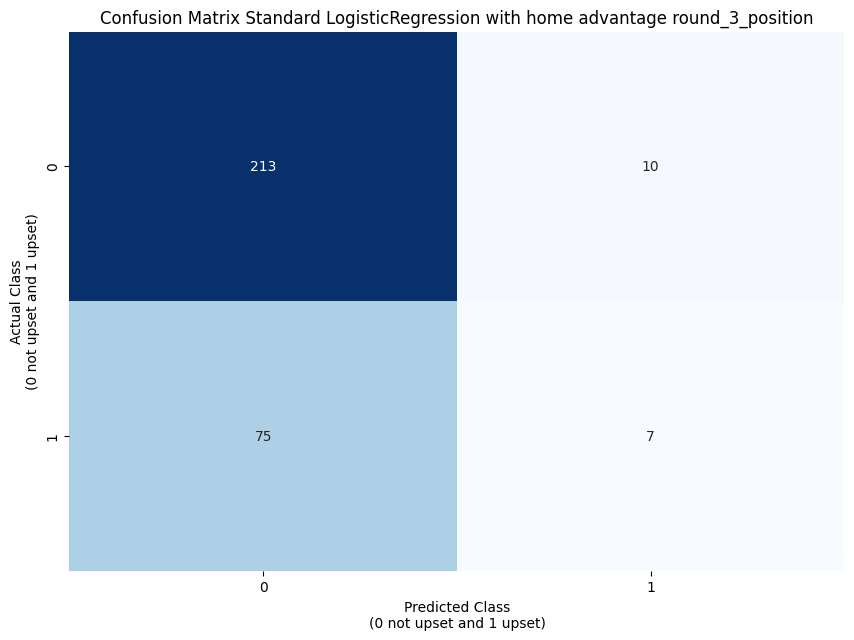

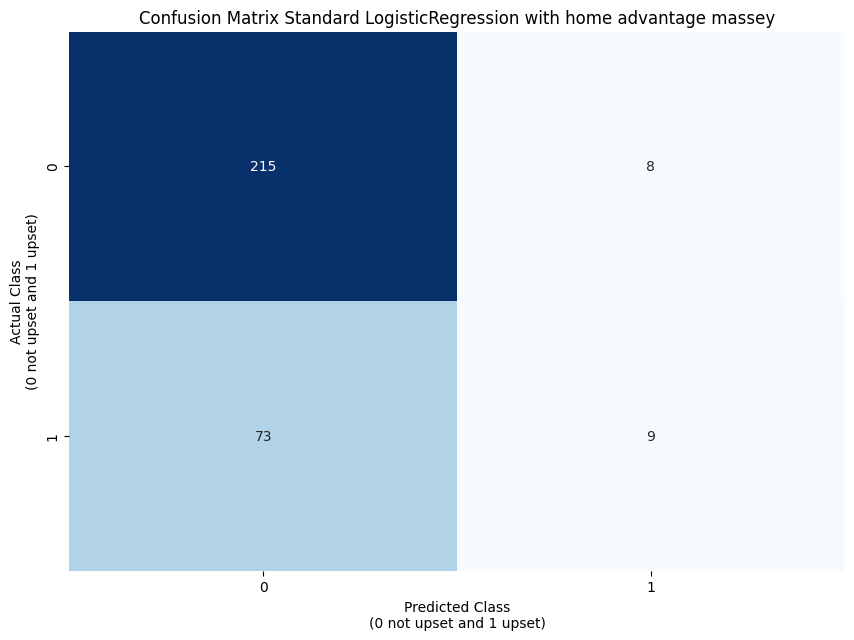

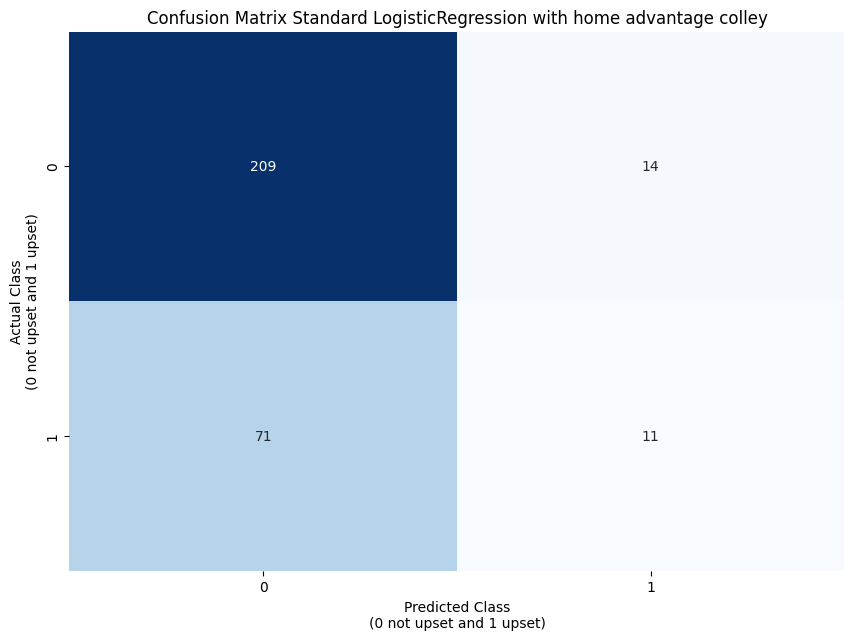

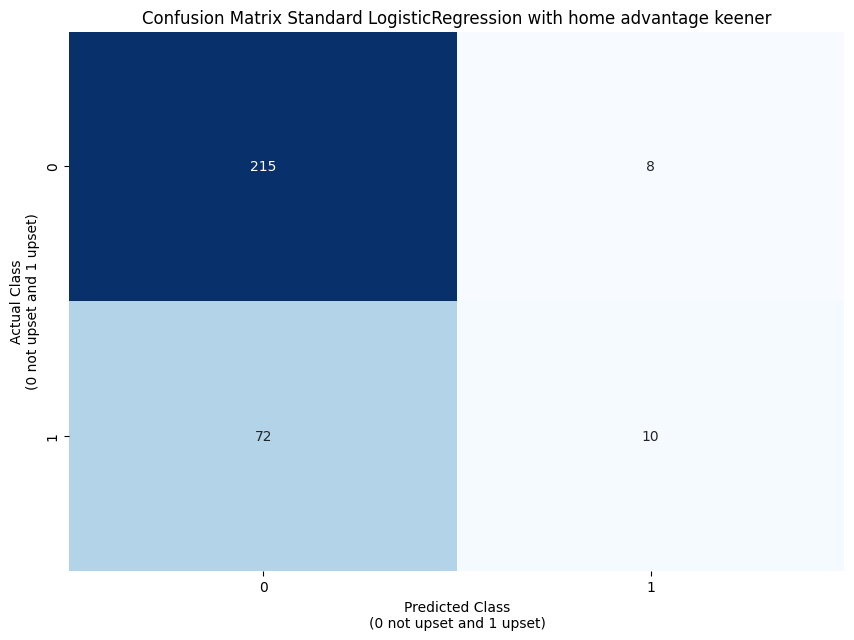

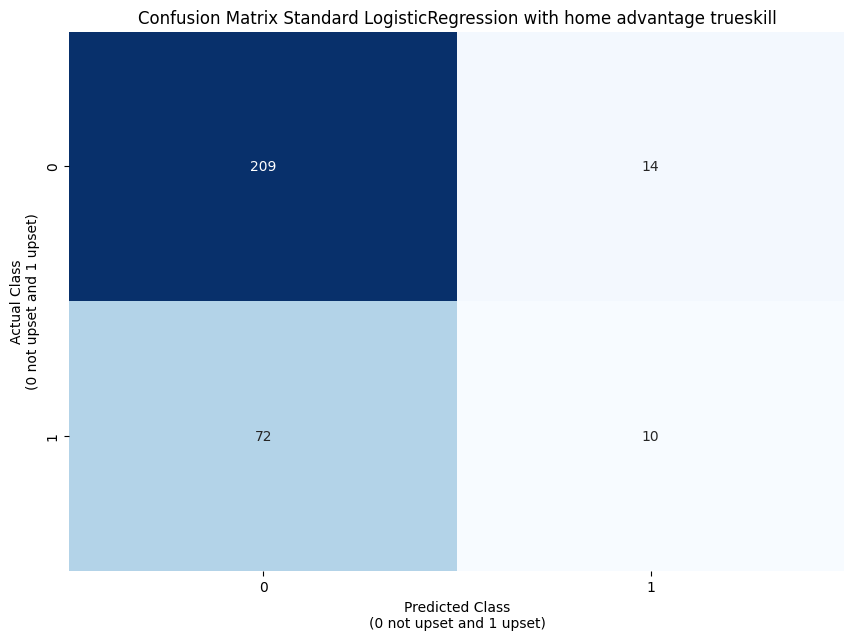

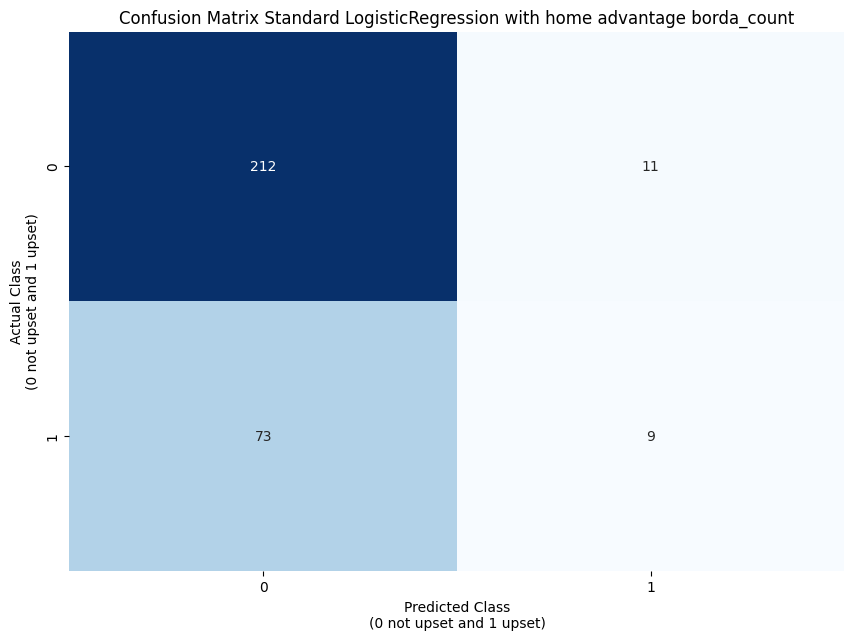

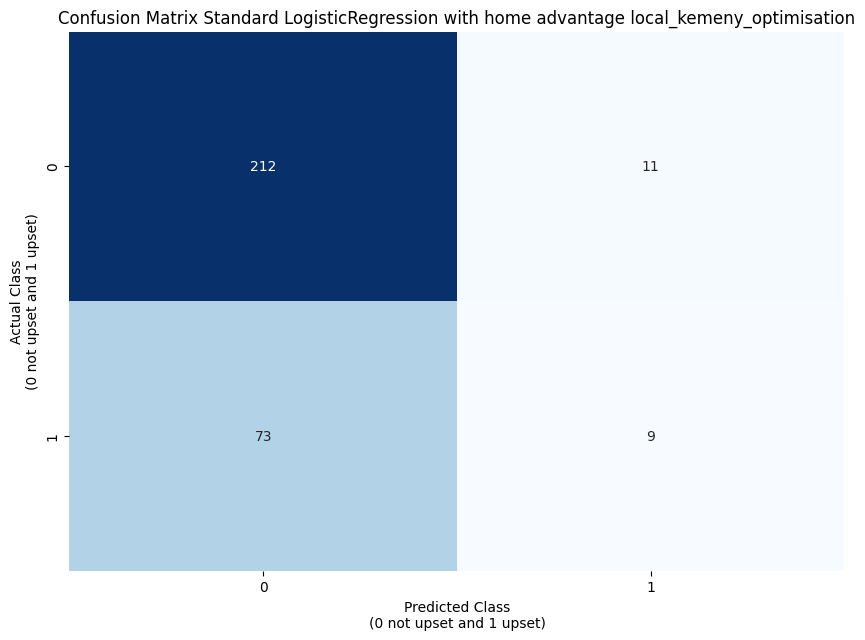

In [16]:
# Standard, no weights
model_name = "Standard LogisticRegression"

# Empty df for consolidating confusion report results
all_results_df_slr = pd.DataFrame(columns=['metric_id', 'metric'])

# Define the ranking systems
ranking_systems = ['round_3_position', 'massey', 'colley', 'keener', 'trueskill', 'borda_count', 'local_kemeny_optimisation']

# Get all columns except the target and ranking columns
target_variable = 'target_variable'
base_features = [col for col in fa_cup_raw_features_df.columns if col != target_variable and not any(f"{team}_{ranking}" in col for team in ['home_team', 'away_team'] for ranking in ranking_systems)]

# Identify numeric and categorical columns
numeric_features = fa_cup_raw_features_df[base_features].select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = fa_cup_raw_features_df[base_features].select_dtypes(include=['object']).columns.tolist()

# Define preprocessing steps

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
     ('imputer', SimpleImputer(strategy='most_frequent')),
     ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

ranking_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

# Define cross-validation strategy
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Loop through each ranking system
for ranking in ranking_systems:
    #print(f"\nRunning model for {ranking} ranking system")
    model_name_ranking = f"{model_name} {ranking}"
    print(model_name_ranking)

    # Prepare the feature set for the current ranking system
    current_features = base_features + [f'home_team_{ranking}', f'away_team_{ranking}']
    X = fa_cup_raw_features_df[current_features]
    y = fa_cup_raw_features_df['target_variable']

    # Update preprocessor with current features
    #preprocessor = ColumnTransformer(
     #   transformers=[
      #      ('num', numeric_transformer, numeric_features),
       #     ('cat', categorical_transformer, categorical_features),
        #    ('rank', ranking_transformer, [f'home_team_{ranking}', f'away_team_{ranking}'])
        #], verbose_feature_names_out=False)


    # Initialize lists to store results for each fold of the model
    fold_accuracies = []
    confusion_matrices = []
    classification_reports = []
    all_y_true = []
    all_y_pred = []

    # Perform cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    for fold, (train_index, val_index) in enumerate(skf.split(X, y), 1):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        # Add home advantage factor
        #X_train, home_advantage_column = add_home_advantage(X_train)
        #X_val, _ = add_home_advantage(X_val)

        # Update numeric_features to include the home advantage column
        #numeric_features_with_ha = [home_advantage_column] + numeric_features
        #print(numeric_features_with_ha)

        # Update preprocessor with current features including home advantage
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, numeric_features),
                ('cat', categorical_transformer, categorical_features),
                ('rank', ranking_transformer, [f'home_team_{ranking}', f'away_team_{ranking}'])
            ], verbose_feature_names_out=False)

        # Fit preprocessor and transform data
        X_train_preprocessed = preprocessor.fit_transform(X_train)
        X_val_preprocessed = preprocessor.transform(X_val)

        # Create pipeline
        model = Pipeline([
          ('preprocessor', preprocessor),
          ('classifier', LogisticRegression(max_iter=100))
          ])

        # Get feature names after preprocessing
        feature_names = preprocessor.get_feature_names_out()

        # Convert to DataFrame
        X_train_preprocessed_df = pd.DataFrame(X_train_preprocessed, columns=feature_names, index=X_train.index)
        X_val_preprocessed_df = pd.DataFrame(X_val_preprocessed, columns=feature_names, index=X_val.index)

        # Simple check for missing values
        if X_train_preprocessed_df.isnull().values.any() or X_val_preprocessed_df.isnull().values.any():
          raise ValueError("Missing values found in preprocessed data. Please review your preprocessing steps.")

        #print(f"\nFold {fold}")
        #print("Preprocessed Train data:")
        #display(X_train_preprocessed_df)
        #print("\nPreprocessed Test data:")
        #display(pd.concat([X_val_preprocessed_df, y_val], axis=1))

        # Fit and predict
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        # Calculate accuracy
        accuracy = accuracy_score(y_val, y_pred)
        fold_accuracies.append(accuracy)

        # Confusion matrix
        cm = confusion_matrix(y_val, y_pred)
        confusion_matrices.append(cm)

        # Generate classification report
        cr = classification_report(y_val, y_pred, output_dict=True)
        classification_reports.append(cr)

        # Store true and predicted values for later analysis
        all_y_true.extend(y_val)
        all_y_pred.extend(y_pred)

        print(f"Fold {fold} Accuracy: {accuracy:.3f}")

    # Calculate average accuracy
    avg_accuracy = sum(fold_accuracies) / len(fold_accuracies)
    print(f"Average Accuracy: {avg_accuracy:.3f}")

    # Create and display results using your existing function
    results_df= create_model_results_df(all_y_true, all_y_pred, fold_accuracies, model_name_ranking)
    results_df = results_df.reset_index()
    results_df['metric_id'] = results_df.index + 1
    results_df = results_df[['metric_id', 'metric', model_name_ranking]]

    all_results_df_slr = all_results_df_slr.merge(results_df, on=['metric_id', 'metric'], how='outer')

display(all_results_df_slr)


In [14]:
# Standard, no weights
model_name = "Standard LogisticRegression"

# Empty df for consolidating confusion report results
all_results_df_slrh = pd.DataFrame(columns=['metric_id', 'metric'])

# Define the ranking systems
ranking_systems = ['round_3_position', 'massey', 'colley', 'keener', 'trueskill', 'borda_count', 'local_kemeny_optimisation']

# Get all columns except the target and ranking columns
target_variable = 'target_variable'
base_features = [col for col in fa_cup_raw_features_df.columns if col != target_variable and not any(f"{team}_{ranking}" in col for team in ['home_team', 'away_team'] for ranking in ranking_systems)]

# Identify numeric and categorical columns
numeric_features = fa_cup_raw_features_df[base_features].select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = fa_cup_raw_features_df[base_features].select_dtypes(include=['object']).columns.tolist()

# Define preprocessing steps

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
     ('imputer', SimpleImputer(strategy='most_frequent')),
     ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

ranking_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

# Define cross-validation strategy
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Loop through each ranking system
for ranking in ranking_systems:
    #print(f"\nRunning model for {ranking} ranking system")
    model_name_ranking = f"{model_name} {ranking}"
    print(model_name_ranking)

    # Prepare the feature set for the current ranking system
    current_features = base_features + [f'home_team_{ranking}', f'away_team_{ranking}']
    X = fa_cup_raw_features_df[current_features]
    y = fa_cup_raw_features_df['target_variable']

    # Update preprocessor with current features
    preprocessor = ColumnTransformer(
        transformers=[
            ('home_advantage', home_advantage_transformer, ['home_team_league_level', 'away_team_league_level', 'home_win']),
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features),
            ('rank', ranking_transformer, [f'home_team_{ranking}', f'away_team_{ranking}'])
        ], verbose_feature_names_out=False)


    # Initialize lists to store results for each fold of the model
    fold_accuracies = []
    confusion_matrices = []
    classification_reports = []
    all_y_true = []
    all_y_pred = []

    # Perform cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    for fold, (train_index, val_index) in enumerate(skf.split(X, y), 1):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        # Fit preprocessor and transform data
        X_train_preprocessed = preprocessor.fit_transform(X_train)
        X_val_preprocessed = preprocessor.transform(X_val)

        # Create pipeline
        model = Pipeline([
          ('preprocessor', preprocessor),
          ('classifier', LogisticRegression(max_iter=100))
          ])

        # Get feature names after preprocessing
        feature_names = preprocessor.get_feature_names_out()

        # Convert to DataFrame
        X_train_preprocessed_df = pd.DataFrame(X_train_preprocessed, columns=feature_names, index=X_train.index)
        X_val_preprocessed_df = pd.DataFrame(X_val_preprocessed, columns=feature_names, index=X_val.index)

        # Simple check for missing values
        if X_train_preprocessed_df.isnull().values.any() or X_val_preprocessed_df.isnull().values.any():
          raise ValueError("Missing values found in preprocessed data. Please review your preprocessing steps.")

        #print(f"\nFold {fold}")
        #print("Preprocessed Train data:")
        #display(pd.concat([X_train_preprocessed_df, y_train], axis=1))
        #print("\nPreprocessed Test data:")
        #display(pd.concat([X_val_preprocessed_df, y_val], axis=1))

        # Fit and predict
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        # Calculate accuracy
        accuracy = accuracy_score(y_val, y_pred)
        fold_accuracies.append(accuracy)

        # Confusion matrix
        cm = confusion_matrix(y_val, y_pred)
        confusion_matrices.append(cm)

        # Generate classification report
        cr = classification_report(y_val, y_pred, output_dict=True)
        classification_reports.append(cr)

        # Store true and predicted values for later analysis
        all_y_true.extend(y_val)
        all_y_pred.extend(y_pred)

        print(f"Fold {fold} Accuracy: {accuracy:.3f}")

    # Calculate average accuracy
    avg_accuracy = sum(fold_accuracies) / len(fold_accuracies)
    print(f"Average Accuracy: {avg_accuracy:.3f}")

    # Create and display results using your existing function
    results_df= create_model_results_df(all_y_true, all_y_pred, fold_accuracies, model_name_ranking)
    results_df = results_df.reset_index()
    results_df['metric_id'] = results_df.index + 1
    results_df = results_df[['metric_id', 'metric', model_name_ranking]]

    all_results_df_slrh = all_results_df_slr.merge(results_df, on=['metric_id', 'metric'], how='outer')

display(all_results_df_slrh)


Standard LogisticRegression with home advantage round_3_position


AttributeError: 'tuple' object has no attribute 'size'

In [ ]:
# Weighted Logistc Regression
model_name = "Weighted LogisticRegression"

# Function to calculate weights
def calculate_weights(y):
    class_counts = y.value_counts()
    total_samples = len(y)
    return {class_label: int(round((1 - (count / total_samples)) * 100))
            for class_label, count in class_counts.items()}

# Define the ranking systems
ranking_systems = ['round_3_position', 'massey', 'colley', 'keener', 'trueskill', 'borda_count', 'local_kemeny_optimisation']

# Get all columns except the target and ranking columns
target_variable = 'target_variable'
base_features = [col for col in fa_cup_raw_features_df.columns if col != target_variable and not any(f"{team}_{ranking}" in col for team in ['home_team', 'away_team'] for ranking in ranking_systems)]


# Identify numeric and categorical columns
numeric_features = fa_cup_raw_features_df[base_features].select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = fa_cup_raw_features_df[base_features].select_dtypes(include=['object']).columns.tolist()

# Define preprocessing steps
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
     ('imputer', SimpleImputer(strategy='most_frequent')),
     ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

ranking_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

# Define cross-validation strategy
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Loop through each ranking system
for ranking in ranking_systems:
    model_name_ranking = f"{model_name} {ranking}"
    print(model_name_ranking)

    # Prepare the feature set for the current ranking system
    current_features = base_features + [f'home_team_{ranking}', f'away_team_{ranking}']
    X = fa_cup_raw_features_df[current_features]
    y = fa_cup_raw_features_df['target_variable']

    # Update preprocessor with current features
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features),
            ('rank', ranking_transformer, [f'home_team_{ranking}', f'away_team_{ranking}'])
        ], verbose_feature_names_out=False)

    # Initialize lists to store results for each fold of the model
    fold_accuracies = []
    confusion_matrices = []
    classification_reports = []
    all_y_true = []
    all_y_pred = []

    # Perform cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    for fold, (train_index, val_index) in enumerate(skf.split(X, y), 1):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        # Fit preprocessor and transform data
        X_train_preprocessed = preprocessor.fit_transform(X_train)
        X_val_preprocessed = preprocessor.transform(X_val)

        # Get feature names after preprocessing
        feature_names = preprocessor.get_feature_names_out()

        # Convert to DataFrame
        X_train_preprocessed_df = pd.DataFrame(X_train_preprocessed, columns=feature_names, index=X_train.index)
        X_val_preprocessed_df = pd.DataFrame(X_val_preprocessed, columns=feature_names, index=X_val.index)

        # Calculate weights using only training data
        weights = calculate_weights(y_train)

        # Create pipeline
        model = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', LogisticRegression(class_weight=weights,max_iter=1000))
        ])


        # Simple check for missing values
        if X_train_preprocessed_df.isnull().values.any() or X_val_preprocessed_df.isnull().values.any():
          raise ValueError("Missing values found in preprocessed data. Please review your preprocessing steps.")

        #print(f"\nFold {fold}")
        #print("Preprocessed Train data:")
        #display(pd.concat([X_train_preprocessed_df, y_train], axis=1))
        #print("\nPreprocessed Test data:")
        #display(pd.concat([X_val_preprocessed_df, y_val], axis=1))

        # Fit and predict
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        # Calculate accuracy
        accuracy = accuracy_score(y_val, y_pred)
        fold_accuracies.append(accuracy)

        # Confusion matrix
        cm = confusion_matrix(y_val, y_pred)
        confusion_matrices.append(cm)

        # Generate classification report
        cr = classification_report(y_val, y_pred, output_dict=True)
        classification_reports.append(cr)

        # Store true and predicted values for later analysis
        all_y_true.extend(y_val)
        all_y_pred.extend(y_pred)

        print(f"Fold {fold} Accuracy: {accuracy:.3f}")

    # Calculate average accuracy
    avg_accuracy = sum(fold_accuracies) / len(fold_accuracies)
    print(f"Average Accuracy: {avg_accuracy:.3f}")

    # Create and display results using your existing function
    results_df= create_model_results_df(all_y_true, all_y_pred, fold_accuracies, model_name_ranking)
    results_df = results_df.reset_index()
    results_df['metric_id'] = results_df.index + 1
    results_df = results_df[['metric_id', 'metric', model_name_ranking]]

    all_results_df = all_results_df.merge(results_df, on=['metric_id', 'metric'], how='outer')

display(all_results_df)


In [ ]:
# MCP Neural Network
model_name = "MLP Classifier Neural Network"
random_state= 47

# Define the ranking systems
ranking_systems = ['round_3_position', 'massey', 'colley', 'keener', 'trueskill', 'borda_count', 'local_kemeny_optimisation']

# Get all columns except the target and ranking columns
target_variable = 'target_variable'
base_features = [col for col in fa_cup_raw_features_df.columns if col != target_variable and not any(f"{team}_{ranking}" in col for team in ['home_team', 'away_team'] for ranking in ranking_systems)]


# Identify numeric and categorical columns
numeric_features = fa_cup_raw_features_df[base_features].select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = fa_cup_raw_features_df[base_features].select_dtypes(include=['object']).columns.tolist()

# Define preprocessing steps
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
     ('imputer', SimpleImputer(strategy='most_frequent')),
     ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

ranking_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

# Define cross-validation strategy
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

# Loop through each ranking system
for ranking in ranking_systems:
    #print(f"\nRunning model for {ranking} ranking system")
    model_name_ranking = f"{model_name} {ranking}"
    print(model_name_ranking)

    # Prepare the feature set for the current ranking system
    current_features = base_features + [f'home_team_{ranking}', f'away_team_{ranking}']
    X = fa_cup_raw_features_df[current_features]
    y = fa_cup_raw_features_df['target_variable']

    # Update preprocessor with current features
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features),
            ('rank', ranking_transformer, [f'home_team_{ranking}', f'away_team_{ranking}'])
        ], verbose_feature_names_out=False)


    # Initialize lists to store results for each fold of the model
    fold_accuracies = []
    confusion_matrices = []
    classification_reports = []
    all_y_true = []
    all_y_pred = []

    # Perform cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    for fold, (train_index, val_index) in enumerate(skf.split(X, y), 1):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        # Fit preprocessor and transform data
        X_train_preprocessed = preprocessor.fit_transform(X_train)
        X_val_preprocessed = preprocessor.transform(X_val)

        # Create pipeline
        model = Pipeline([
          ('preprocessor', preprocessor),
          ('classifier', MLPClassifier(hidden_layer_sizes=(10), max_iter=10000, random_state=random_state))
          ])

        # Get feature names after preprocessing
        feature_names = preprocessor.get_feature_names_out()

        # Convert to DataFrame
        X_train_preprocessed_df = pd.DataFrame(X_train_preprocessed, columns=feature_names, index=X_train.index)
        X_val_preprocessed_df = pd.DataFrame(X_val_preprocessed, columns=feature_names, index=X_val.index)

        # Simple check for missing values
        if X_train_preprocessed_df.isnull().values.any() or X_val_preprocessed_df.isnull().values.any():
          raise ValueError("Missing values found in preprocessed data. Please review your preprocessing steps.")

        #print(f"\nFold {fold}")
        #print("Preprocessed Train data:")
        #display(pd.concat([X_train_preprocessed_df, y_train], axis=1))
        #print("\nPreprocessed Test data:")
        #display(pd.concat([X_val_preprocessed_df, y_val], axis=1))

        # Fit and predict
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        # Calculate accuracy
        accuracy = accuracy_score(y_val, y_pred)
        fold_accuracies.append(accuracy)

        # Confusion matrix
        cm = confusion_matrix(y_val, y_pred)
        confusion_matrices.append(cm)

        # Generate classification report
        cr = classification_report(y_val, y_pred, output_dict=True)
        classification_reports.append(cr)

        # Store true and predicted values for later analysis
        all_y_true.extend(y_val)
        all_y_pred.extend(y_pred)

        print(f"Fold {fold} Accuracy: {accuracy:.3f}")

    # Calculate average accuracy
    avg_accuracy = sum(fold_accuracies) / len(fold_accuracies)
    print(f"Average Accuracy: {avg_accuracy:.3f}")

    # Create and display results using your existing function
    results_df= create_model_results_df(all_y_true, all_y_pred, fold_accuracies, model_name_ranking)
    results_df = results_df.reset_index()
    results_df['metric_id'] = results_df.index + 1
    results_df = results_df[['metric_id', 'metric', model_name_ranking]]

    all_results_df = all_results_df.merge(results_df, on=['metric_id', 'metric'], how='outer')

display(all_results_df)
